# Analysis of Heat Wave Definitions

In [1]:
### Import all required libraries

import xarray as xr
import dask
import numpy as np
from scipy.stats import norm
import pymannkendall as mk
import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
from cartopy import feature, crs
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
import os
from cdo import *
cdo = Cdo()
import warnings
warnings.filterwarnings('ignore')
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import glob

In [2]:
## Specify path to the file
path='/media/kenz/1B8D1A637BBA134B/CHIRTS'
# cdo = Cdo('~/media/kenz/1B8D1A637BBA134B/CHIRTS/scripts/tmp/')

In [3]:
### specify file names

tmax = 'Tmax/chirts.Tmax.1983.2016.WA.days_p25.nc'
tmin = 'Tmin/chirts.Tmin.1983.2016.WA.days_p25.nc'

tmax90 = 'Tmax/chirts.Tmax90.1983.2016.WA.days_p25.nc'
tmin90 = 'Tmin/chirts.Tmin90.1983.2016.WA.days_p25.nc'

tmean = 'Tmean/chirts.Tmean.1983.2016.WA.days_p25.nc'
tmean95 = 'Tmean/chirts.clim.Tmean95.1983.2016.WA.days_p25.nc'
# Tmean/chirts.clim.Tmean95.1983.2016.WA.days_p25.nc

tmean_accl = 'Tmean/accl.nc'
tmean_sig = 'Tmean/sig95.nc'

In [4]:
### Defining functions  ###

def set_fig_params(axes):
    for i,j in enumerate(axes):
    # for i in (range(0,len(axes))):
        ax[i].set_extent([-19,15,4,24])
        ax[i].add_feature(feature.COASTLINE)
        ax[i].add_feature(feature.BORDERS)
        ax[i].add_feature(feature.STATES, linewidth = 0.2)
        ax[i].set_xticks([-20,-10,0,10], crs=crs.PlateCarree())
        ax[i].set_yticks([5,10,15,20], crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax[i].xaxis.set_major_formatter(lon_formatter)
        ax[i].yaxis.set_major_formatter(lat_formatter)
def sens_slope(data):
    data = data.groupby('time.year').mean('time')
    data = data.sel(longitude=np.arange(-19.875, 21.875,0.25), latitude=np.arange(3.125,26.875,0.25), method = 'nearest')
    output=[]
    for i in np.arange(len(data.latitude.values)):
        for j in np.arange(len(data.longitude.values)):
            try:
                slope_val = mk.sens_slope(data[:,i,j]).slope
            except:
                slope_val = np.nan
            output.append(slope_val)

    output = np.copy(output).reshape(data.latitude.size,data.longitude.size)
    slopes=xr.DataArray(output, dims=('latitude','longitude'), coords={'latitude':data.latitude,'longitude':data.longitude})
    return slopes

def rising_filter(array, axis):

    # Make sure there are enough points
    assert(array.shape[axis] == 5)
    # Make sure we're working on the last axis
    assert(axis == array.ndim-1 or axis == -1)
    
    left = array[..., 1]
    right = array[..., 2:].sum(axis=axis)

    return np.logical_and(np.isnan(left), np.isfinite(right))

def rising_filter_dask(x, dim):

    return xr.apply_ufunc(rising_filter, x, input_core_dims=[[dim]],
                             kwargs={'axis': -1},
                             dask='parallelized',
                             output_dtypes=[bool])
def HWD(data):
    # s = data>0
    # s = s.drop_duplicates('time')
    # candidates = tx.where(s)
    windows = data.chunk({'time':20}).rolling(time=5, center=True, min_periods=1).construct('rolling_dim')
    heatwave_starts = rising_filter_dask(windows, dim='rolling_dim')
    return heatwave_starts


In [5]:
def sens_slopes(data):
    data = data.sel(longitude=np.arange(-19.875, 21.875,0.25), latitude=np.arange(3.125,26.875,0.25), method = 'nearest')
    output=[]
    for i in np.arange(len(data.latitude.values)):
        for j in np.arange(len(data.longitude.values)):
            try:
                slope_val = mk.sens_slope(data[:,i,j]).slope
            except:
                slope_val = np.nan
            output.append(slope_val)

    output = np.copy(output).reshape(data.latitude.size,data.longitude.size)
    slopes=xr.DataArray(output, dims=('latitude','longitude'), coords={'latitude':data.latitude,'longitude':data.longitude})
    return slopes

In [6]:
### More Functions ###
# def df_read(path,file,var):
#     ds = xr.open_dataset(f'{path}/{file}')[f'{var}']
#     # [f'{temperature_type}']
#     return ds
def df_read(path,file,var):
    ds = xr.open_dataset(f'{path}/{file}')[f'{var}'].sortby('time').drop_duplicates('time').sel(time=slice('1983',None))
    return ds
def sellonlat(data):
    return data.sel(longitude=10,latitude=10,method='nearest')
def selone(data):
    return data.sel(time='2010')
def mask_temp(path,data,pctl):
    sub = cdo.sub(input = ' '.join((f'{path}/{data}', f'{path}/{pctl}')))
    temp = df_read(path,data,str(data[:4])).chunk({'time':5000})
    extreme = xr.open_dataset(sub)[f'{data}'[:4]].drop_duplicates('time')
    data = temp.where(extreme>0)
    return data
def remove_temp_files():
    for i in glob.glob('/tmp/cdo*'):
        os.remove(i)

# def HWF(path,file, temperature_type='Tmax',var='Tmax'):
#     if temperature_type not in ['Tmax', 'Tmin']:
#         raise ValueError("Invalid temperature_type. Use 'Tmax' or 'Tmin'.")
#     path,file, temperature_type = path,file, temperature_type
#     ds = df_read(path,file,var)
#     ds = HWD(ds).sel(time=slice('1983', '2016')).sum('time') / 30
#     ds = cal_ct90(path, temperature_type=temperature_type).groupby('time.year').count('time').mean('year')*ds
#     return ds

# def HWF_ehf(path, file, var):
#     ds = df_read(path, file,var).sortby('time').chunk({'time':5})
#     mask = ds.where(ds>0, drop = True)
#     ehf_hwd = mask.rolling(time=3).sum().sel(time=slice('1983', '2016')).mean('time')
#     ehf = abs(ds.mean('time'))
#     return ehf*ehf_hwd


In [7]:
accl = df_read(path,tmean_accl,'Tmax').chunk({'time':2700})
sig = df_read(path,tmean_sig,'Tmax').chunk({'time':2700})
accl = xr.where(accl<=1,1,accl)
sig = xr.where(sig<0,0,sig)
ehf = accl*sig
ehf = ehf.where(ehf>0)
ds_gtehf = ehf.groupby('time.year').count()

In [8]:
ehf_f = ehf.chunk({'time':-1,'longitude':20,'latitude':20})

In [9]:
# ehw_ehf.plot()

In [9]:
%%time
hwf_ehf = ehf_f.groupby('time.year').sum().mean('year')
hwf_ehf = hwf_ehf.compute()

CPU times: user 10.9 s, sys: 12.5 s, total: 23.4 s
Wall time: 13.2 s


In [10]:
remove_temp_files()

In [11]:
tx = mask_temp(path,tmax,tmax90)
tn = mask_temp(path,tmin,tmin90)

In [12]:
ds_gtx = tx.groupby('time.year').count('time')

In [13]:
ds_gtn = tn.groupby('time.year').count('time')

In [14]:
windows = tx.chunk({'time':20}).rolling(time=5, center=True, min_periods=1).construct('rolling_dim')
hwn_tx = rising_filter_dask(windows, dim='rolling_dim')

windows = tn.chunk({'time':20}).rolling(time=5, center=True, min_periods=1).construct('rolling_dim')
hwn_tn = rising_filter_dask(windows, dim='rolling_dim')

#### HWN for Maximum Temperature

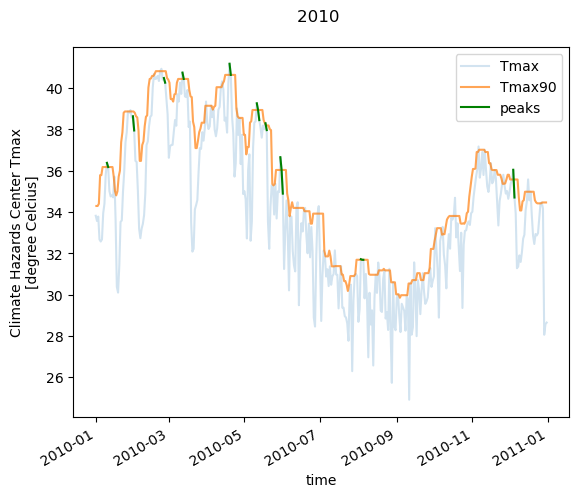

In [21]:
selone(sellonlat(df_read(path,tmax,'Tmax'))).plot(label = 'Tmax', alpha = 0.2)
selone(sellonlat(df_read(path,tmax90,'Tmax'))).plot(label = 'Tmax90', alpha = 0.7)
selone(sellonlat(tx)).plot(label ='peaks', color='green')
plt.legend()
plt.title('2010 \n')
# plt.savefig(f'{path}/figures/Tem and Peaks.jpeg')

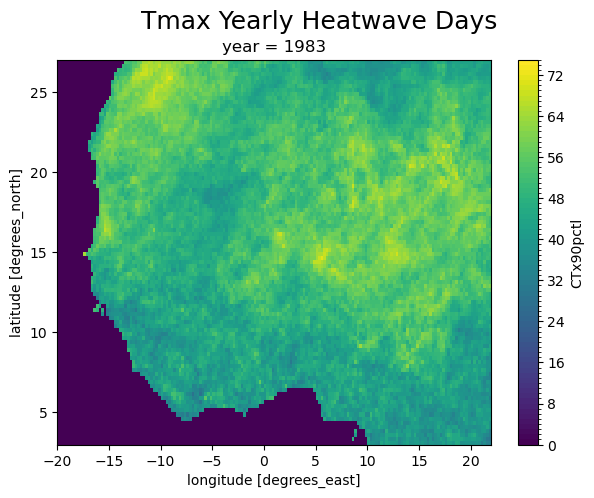

In [22]:
levels = range(int(ds_gtx.max()))
fig, axes = plt.subplots(figsize=[7,5])#ncols=1) #Creating the basis for the plot
def animate(time):
    ds_gtx.isel(year=time).plot(levels=levels, ax=axes, add_colorbar= False)

ani = animation.FuncAnimation(fig, animate, ds_gtx.year.size, interval=400, blit=False)

mld= ds_gtx.isel(year=0).plot.contourf(levels=levels, ax=axes, add_colorbar= False)
cbar= fig.colorbar(mld)
cbar.set_label('CTx90pctl')
fig.suptitle("Tmax Yearly Heatwave Days", fontsize= 18)

HTML(ani.to_jshtml())

In [23]:
ani.save('figures/Tmax_10_day_window_avearged_yearly_heatwave_events.gif', writer='imagemagick', fps = 2) #Save animation as gif-file

#### HWN for Minimum Temperature

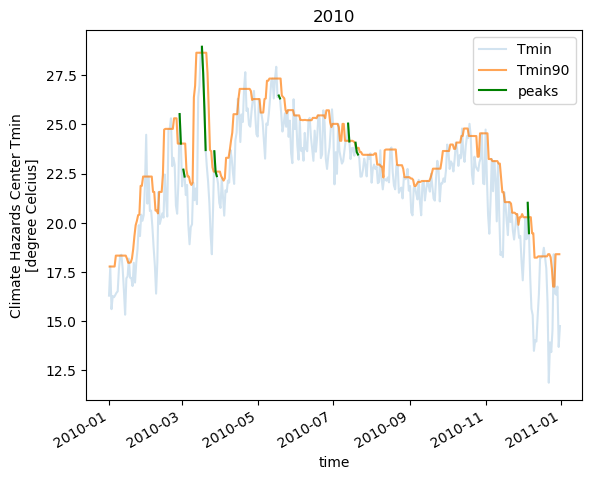

In [25]:
selone(sellonlat(df_read(path,tmin,'Tmin'))).plot(label = 'Tmin', alpha = 0.2)
selone(sellonlat(df_read(path,tmin90,'Tmin'))).plot(label = 'Tmin90', alpha=0.7)
selone(sellonlat(tn)).plot(label ='peaks', color='green')
plt.legend()
plt.title('2010')
plt.savefig(f'{path}/figures/Tmin and Peaks.jpeg')

In [10]:
# # ds_tn_gt_tn90 = mask_temp(path,tmin,tmin90)
# ds_tn_gt_tn90 = tn
# ds_gtn = ds_tn_gt_tn90.groupby('time.year').count('time')
# ds_gtn = ds_gtn.load()

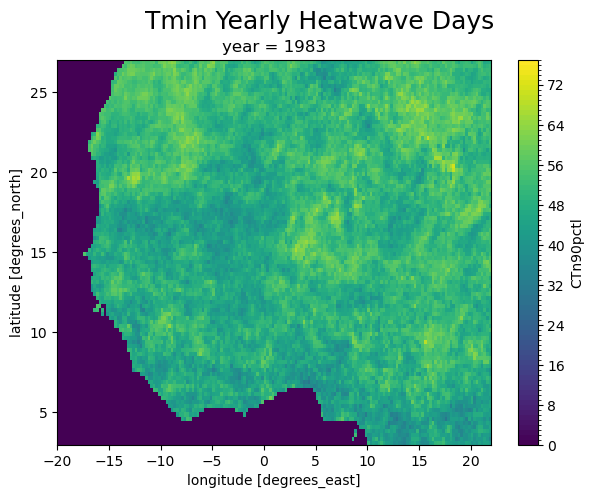

In [26]:
levels = range(int(ds_gtn.max()))
fig, axes = plt.subplots(figsize=[7,5])#ncols=1) #Creating the basis for the plot
def animate(time):
    ds_gtn.isel(year=time).plot(levels=levels, ax=axes, add_colorbar= False)

ani = animation.FuncAnimation(fig, animate, ds_gtn.year.size, interval=400, blit=False)

mld= ds_gtn.isel(year=0).plot.contourf(levels=levels, ax=axes, add_colorbar= False)
cbar= fig.colorbar(mld)
cbar.set_label('CTn90pctl')
fig.suptitle("Tmin Yearly Heatwave Days", fontsize= 18)

HTML(ani.to_jshtml())

In [28]:
ani.save(f'{path}/figures/Tmin_10_day_window_avearged_yearly_heatwave_events.gif', writer='imagemagick', fps = 2) #Save animation as gif-file

#### Calculating HWN for EHF

In [135]:
### calculate this once to store and open

# yearmax = cdo.yearmax(input = f'{path}/{tmean}')
# yearmin = cdo.yearmin(input = f'{path}/{tmean}')
# cdo.yearpctl('95',input = "{} {} {}".format(f'{path}/{tmean}', yearmin, yearmax),output ='Tmean/chirts.clim.Tmean95.1983.2016.WA.days_p25.nc')

# cdo.runmean('3',input = f'{path}/{tmean}',output = 'Tmean/r3_95.nc')
# cdo.runmean('30', input = f'{path}/{tmean}',output = 'Tmean/r30_95.nc')
# cdo.sub(input="{} {}".format('Tmean/r3_95.nc', 'Tmean/r30_95.nc'), output='Tmean/accl.nc')
# cdo.sub(input="{} {}".format('/Tmean/r3_95.nc', f'{path}/{tmean95}'), output='Tmean/sig95.nc')

In [18]:
# cdo.sub(input="{} {}".format(f'{path}/Tmean/r3_95.nc', f'{path}/{tmean95}'), output='Tmean/sig95.nc')

In [10]:
# accl = df_read(path,tmean_accl,'Tmax').chunk({'time':5000})
# sig = df_read(path,tmean_sig,'Tmax').chunk({'time':5000})
# accl = xr.where(accl<=1,1,accl)
# sig = xr.where(sig<0,0,sig)
# ehf = accl*sig
# ehf = ehf.where(ehf>0)

In [11]:
# ds_gtehf = ehf.groupby('time.year').count()

In [ ]:
levels = range(int(ds_gtehf.max()))
fig, axes = plt.subplots(figsize=[7,5])#ncols=1) #Creating the basis for the plot
def animate(time):
    ds_gtehf.isel(year=time).plot(levels=levels, ax=axes, add_colorbar= False)

ani = animation.FuncAnimation(fig, animate, ds_gtehf.year.size, interval=400, blit=False)

mld= ds_gtehf.isel(year=0).plot.contourf(levels=levels, ax=axes, add_colorbar= False)
cbar= fig.colorbar(mld)
cbar.set_label('EHF')
fig.suptitle("EHF Yearly Heatwave Days", fontsize= 18)

HTML(ani.to_jshtml())

In [ ]:
ani.save(f'{pathfigures/EHF_95_Tmean_day_window_avearged_yearly_heatwave_events.gif', writer='imagemagick', fps = 2) #Save animation as gif-file

#### Calculating Heatwave Number (HWN)  #####

 - Heatwaves are defined as a period of `at least three (3) days` where for each day the Maximum or Minimum temperature is in the top 10% for that day of the year.
 - **NB**: EHF is already in a three (3) average therefore satisfying `consecutive three (3) days` requirement of a heatwave.

CPU times: user 1min 52s, sys: 40.7 s, total: 2min 33s
Wall time: 1min 43s


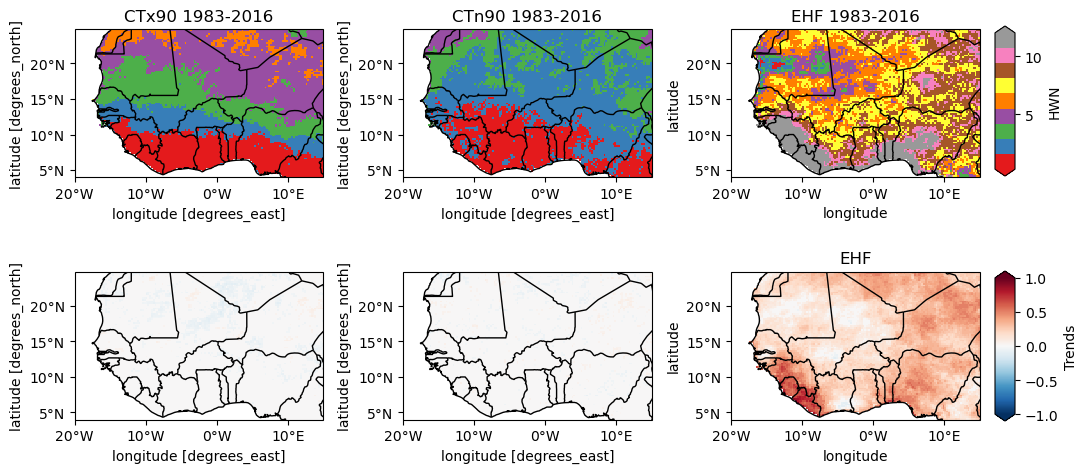

In [14]:
%%time

# Create subplots
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10, 5), subplot_kw={'projection': crs.PlateCarree()})
ax = ax.flatten()
set_fig_params(ax)

# Plot data
vmax=12
# cc = 'gist_heat_r'# plt.savefig(f'{path}/figures/Tem and Peaks.jpeg')
cc='Set1'
### cb1 = ds_gtx.mean('year').plot(ax=ax[0], cmap=cc, vmax=60, add_colorbar=False)
# cb1 = ds_gtx.where(ds_gtx>0).mean('year').plot(ax=ax[0], cmap=cc, vmax=55, vmin=35, add_colorbar=False)

hwdtx = hwn_tx.sum('time')/33
cb1 = hwdtx.where(hwdtx>0).plot(ax=ax[0], cmap=cc, vmax=vmax, add_colorbar=False)
ax[0].set_title('CTx90 1983-2016')

### ds_gtn.mean('year').plot(ax=ax[1], cmap=cc, vmax=60, add_colorbar=False)
# ds_gtn.where(ds_gtn>0).mean('year').plot(ax=ax[1], cmap=cc, vmax=55,  vmin=35, add_colorbar=False)

hwdtn = (hwn_tn.sum('time')/33)
hwdtn.where(hwdtn>0).plot(ax=ax[1], cmap=cc, vmax=vmax, add_colorbar=False)
ax[1].set_title('CTn90 1983-2016')

ds_gtehf.where(ds_gtehf>0).mean('year').plot(ax=ax[2], cmap=cc, vmax=vmax, add_colorbar=False)
ax[2].set_title('EHF 1983-2016')

cm = 'RdBu_r'
vm = 1

# cb2 = sens_slopes(ds_gtx.where(ds_gtx>0).load()).plot(ax=ax[3], vmax=vm, cmap=cm, add_colorbar=False)
# ax[3].set_title('CTx90')


txsl = hwn_tx.groupby('time.year').sum('time')
# txsl = txsl.where(txsl>0).load()
cb2 = sens_slopes(txsl.where(txsl>0).load()).plot(ax=ax[3], vmax=vm, cmap=cm, add_colorbar=False)


tnsl = hwn_tn.groupby('time.year').sum('time')
sens_slopes(tnsl.where(tnsl>0).load()).plot(ax=ax[4], vmax=vm, cmap=cm, add_colorbar=False)

sens_slopes(ds_gtehf.where(ds_gtehf>0).load()).plot(ax=ax[5], cmap=cm, vmax=vm, add_colorbar=False)
ax[5].set_title('EHF')

# # cb = [cb1, cb2]
label = ['HWN','Trends']

# cax2 = fig.add_axes([1,0.62,0.02,0.3])
# fig.colorbar(cb3,cax = cax2, orientation='vertical', extend='both',label='ehf')
cb = [cb1, cb2]
# Add colorbars
for i, j in enumerate([0.62, 0.13]):
    cax = fig.add_axes([1, j, 0.02, 0.3])
    fig.colorbar(cb[i], cax=cax, orientation='vertical', extend='both', label = label[i])

fig.tight_layout()
plt.savefig(path+'/figures/Climatologies of Yearly Heatwaves.jpeg', bbox_inches='tight')

#### Length of the Longest Yearly Event (HWD) ####

CPU times: user 1min 48s, sys: 38.3 s, total: 2min 26s
Wall time: 1min 38s


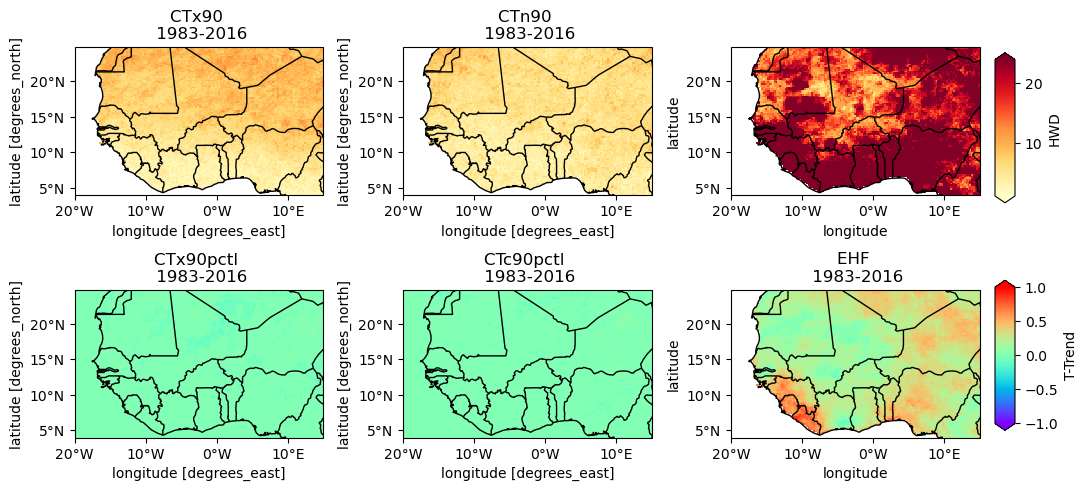

In [14]:
%%time

# Create subplots
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10, 5), subplot_kw={'projection': crs.PlateCarree()})
ax = ax.flatten()
set_fig_params(ax)

vmax = 24
vmax1 = 1
vmin1 = -1
# windows = candidates.chunk({'time':20}).rolling(time=5, center=True, min_periods=1).construct('rolling_dim')
# heatwave_starts = rising_filter_dask(windows, dim='rolling_dim')
cm = 'YlOrRd'
cc = 'rainbow'

sens_slopes((ds_gtehf.where(ds_gtehf>0)).load()).plot(ax=ax[5], cmap=cc, add_colorbar=False)

# g=(HWD(tx)).groupby('time.year').sum('time').max('year')
# cb1 = g.where(g>0).plot(ax=ax[0], cmap=cm, add_colorbar=False, vmax=vmax)

hdtx = hwn_tx.groupby('time.year').sum('time').max('year')
cb1 = hdtx.where(hdtx>0).plot(ax=ax[0], cmap=cm, add_colorbar=False, vmax=vmax)
ax[0].set_title('CTx90 \n 1983-2016')


# (HWD(tn)).groupby('time.year').sum('time').max('year').plot(ax=ax[1], cmap=cm, add_colorbar=False, vmax=vmax)
hdtn = hwn_tn.groupby('time.year').sum('time').max('year')
hdtn.where(hdtn>0).plot(ax=ax[1], cmap=cm, add_colorbar=False, vmax=vmax)
ax[1].set_title('CTn90 \n 1983-2016')

# ehf.mean('time').plot(ax=ax[2], cmap=cm, add_colorbar=False, vmax=vmax)

# ds_gtehf.where(ds_gtehf>0).mean('year').plot(ax=ax[2], cmap=cm, vmax=vmax, add_colorbar=False)

ds_gtehf.where(ds_gtehf>0).max('year').plot(ax=ax[2], cmap=cm, vmax=vmax, add_colorbar=False)
ax[2].set_title('EHF \n 1983-2016')

# sens_slopes((HWD(tx.load())).groupby('time.year').sum('time').load()).plot()

cb2 = sens_slopes((HWD(tx.load())).groupby('time.year').sum('time').load()).plot(ax=ax[3], cmap=cc, add_colorbar=False, vmax = vmax1, vmin=vmin1)
sens_slopes((HWD(tn.load())).groupby('time.year').sum('time').load()).plot(ax=ax[4], cmap=cc, add_colorbar=False, vmax = vmax1, vmin=vmin1)
# sens_slopes((ds_gtehf.where(ds_gtehf>0)).load()).plot(ax=ax[5], cmap=cc, add_colorbar=False, vmax = vmax1, vmin=vmin1)

# sens_slope(tn.load()).plot(ax=ax[4], cmap=cc, add_colorbar=False, vmax = vmax1, vmin=vmin1)
# sens_slope(ehf.load()).plot(ax=ax[5], cmap=cc, add_colorbar=False, vmax = vmax1, vmin = vmin1)


ax[3].set_title('CTx90pctl \n 1983-2016')
ax[4].set_title('CTc90pctl \n 1983-2016')
ax[5].set_title('EHF \n 1983-2016')

# Add colorbar
cb = [cb1, cb2]
labels = ['HWD','Trend']
# cax2 = fig.add_axes([1,0.13,0.02,0.3])
# fig.colorbar(cb3,cax = cax2, orientation='vertical', extend='both',label='ehf-Trend')

for i, j in enumerate([0.585, 0.13]):
    cax = fig.add_axes([1, j, 0.02, 0.3])
    fig.colorbar(cb[i], cax=cax, orientation='vertical', extend='both', label=labels[i])

fig.tight_layout()
plt.savefig(path+'/figures/lenght of the longest heatwave.jpeg', bbox_inches='tight')

##### Annual Sum of Contributing Heat wave Days (HWF)

CPU times: user 1min 55s, sys: 1min 13s, total: 3min 9s
Wall time: 1min 55s


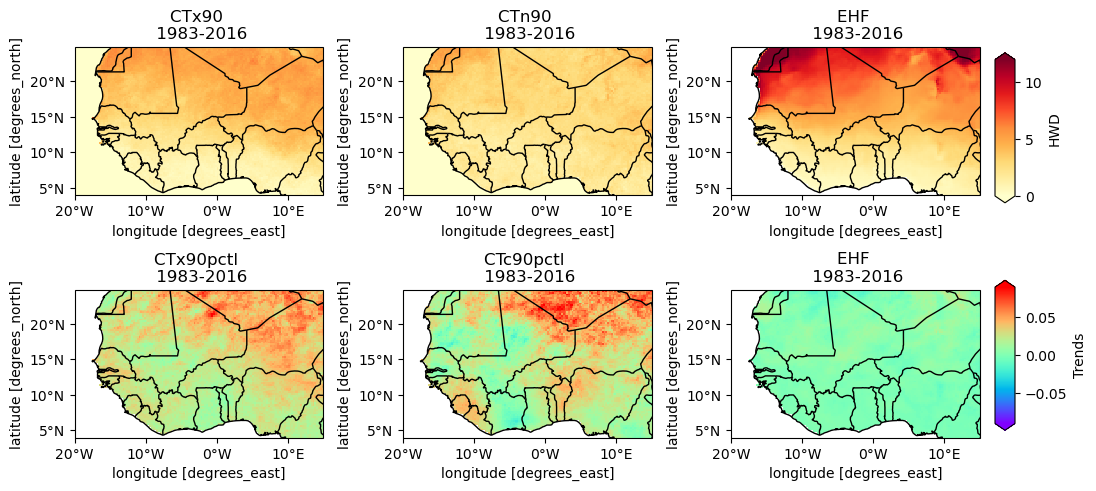

In [ ]:
%%time

# Create subplots
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10, 5), subplot_kw={'projection': crs.PlateCarree()})
ax = ax.flatten()
set_fig_params(ax)

vmax = 12
vmax1 = 0.09
vmin1 = -0.09
# windows = candidates.chunk({'time':20}).rolling(time=5, center=True, min_periods=1).construct('rolling_dim')
# heatwave_starts = rising_filter_dask(windows, dim='rolling_dim')
cm = 'YlOrRd'
cc = 'rainbow'

cb1 = (HWD(tx).sum('time') / 34).plot(ax=ax[0], cmap=cm, add_colorbar=False, vmax=vmax)
ax[0].set_title('CTx90 \n 1983-2016')

(HWD(tn).sum('time') / 34).plot(ax=ax[1], cmap=cm, add_colorbar=False, vmax=vmax)
ax[1].set_title('CTn90 \n 1983-2016')

# (HWD(ehf).sum('time') / 34).plot(ax=ax[2], cmap=cm, add_colorbar=False, vmax=vmax)
# ehf = ehf.chunk({'time':1000})
# mask = (df_read(path,tmean_accl,'Tmax')*abs(df_read(path,tmean_sig,'Tmax'))).chunk({'time':1000}).where(ehf>0,drop=True)
# mask = ehf.where(ehf>0,drop=True)
# (mask.rolling(time=3).sum()).mean('time').plot(ax=ax[2], cmap=cm, add_colorbar=False, vmax=vmax)

# ehf = df_read(path,tmean_accl,'Tmax')*abs(df_read(path,tmean_sig,'Tmax'))
(ehf.where(ehf>0,drop=True).rolling(time=3).sum()).mean('time').plot(ax=ax[2], cmap=cm, add_colorbar=False, vmax=vmax)
ax[2].set_title('EHF \n 1983-2016')

cb2 = sens_slope(tx.load()).plot(ax=ax[3], cmap=cc, add_colorbar=False, vmax = vmax1, vmin=vmin1)
sens_slope(tn.load()).plot(ax=ax[4], cmap=cc, add_colorbar=False, vmax = vmax1, vmin=vmin1)
sens_slope(ehf.load()).plot(ax=ax[5], cmap=cc, add_colorbar=False, vmax = vmax1, vmin = vmin1)


ax[3].set_title('CTx90pctl \n 1983-2016')
ax[4].set_title('CTc90pctl \n 1983-2016')
ax[5].set_title('EHF \n 1983-2016')

# Add colorbar
cb = [cb1, cb2]
labels = ['HWD','Trends']
# Add colorbars
for i, j in enumerate([0.585, 0.13]):
    cax = fig.add_axes([1, j, 0.02, 0.3])
    fig.colorbar(cb[i], cax=cax, orientation='vertical', extend='both', label=labels[i])
    
fig.tight_layout()
plt.savefig(path+'/figures/graph22.jpeg', bbox_inches='tight')

### Climatologies of Yearly Sum of participating heat wave days
   -  Average lenght of the yearly heat wave days x Average heatwave 
   -  yearly heatwave x length of yearly heat wave event / average
   
HWN x Average_lenght

In [16]:
yearly_av_hw_tx = hwn_tx.sum('time')/33
lenght_av_hw_tx = hwn_tx.groupby('time.year').sum('time').mean('year')
hwf_tx = yearly_av_hw_tx*lenght_av_hw_tx

In [17]:
yearly_av_hw_tn = hwn_tn.sum('time')/33
lenght_av_hw_tn = hwn_tn.groupby('time.year').sum('time').mean('year')
hwf_tn = yearly_av_hw_tn*lenght_av_hw_tn

CPU times: user 27.5 s, sys: 9.03 s, total: 36.6 s
Wall time: 16.4 s


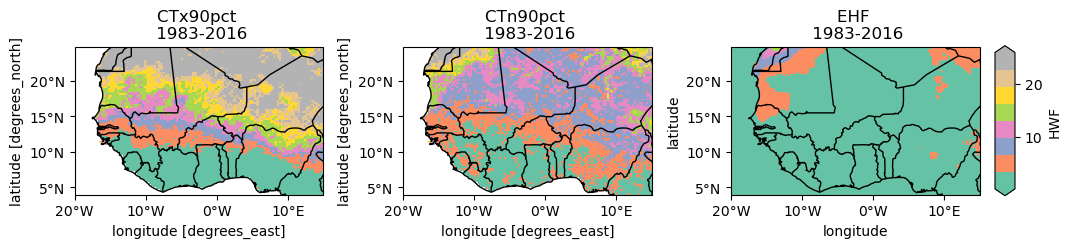

In [18]:
%%time

# tx = xr.open_dataset(f'{path1}/Tmax/chirts.Tmax.1983.2016.WA.days_p25.nc').Tmax.sortby('time').drop_duplicates('time').chunk({'time': 20})
# tn = xr.open_dataset(f'{path1}/Tmin/chirts.Tmin.1983.2016.WA.days_p25.nc').Tmin.sortby('time').drop_duplicates('time').chunk({'time': 20})

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 5), subplot_kw={'projection': crs.PlateCarree()})
ax = ax.flatten()
set_fig_params(ax)

vmax = 26

# cm = 'viridis'
cc = 'Set2'

cb = hwf_tx.where(hwf_tx>0).plot(ax=ax[0], cmap=cc, vmax=vmax, add_colorbar=False)

# .plot(ax=ax[0], cmap=cc, vmax=vmax, add_colorbar=False)

hwf_tn.where(hwf_tn>0).plot(ax=ax[1], cmap=cc, vmax=vmax, add_colorbar=False)

# ehf.groupby('time.year').sum().mean('year').plot(ax=ax[2], cmap=cc, add_colorbar=False)
# (ehf.where(ehf>0,drop=True).rolling(time=3).sum()).mean('time').plot(ax=ax[2], cmap=cc, add_colorbar=False)
hwf_ehf.plot(ax=ax[2], cmap=cc, add_colorbar=False)
ax[2].set_title('EHF \n 1983-2016')



# sens_slope(HWF(path1, 'Tmax/tx-tx90.nc', temperature_type='Tmax', var = 'Tmax')).plot(ax=ax[3], cmap=cc)
# sens_slope(HWF(path1, 'Tmin/tn-tn90.nc', temperature_type='Tmin', var = 'Tmin')).plot(ax=ax[4], cmap=cc)
# sens_slope(HWF_ehf(path1, 'scripts/EHF.nc', var = 'Tmax')).plot(ax=ax[5], cmap=cc)

ax[0].set_title('CTx90pct \n 1983-2016')
ax[1].set_title('CTn90pct \n 1983-2016')
# ax[5].set_title('EHF \n 1983-2016')

# cb = [cb1, cb2]
# labels = ['HWF','Trends']
# # Add colorbars
# for i, j in enumerate([0.59, 0.13]):
#     cax = fig.add_axes([1, j, 0.02, 0.3])
#     fig.colorbar(cb[i], cax=cax, orientation='vertical', extend='both', label=labels[i])
cax = fig.add_axes([1,0.35,0.02,0.3])
fig.colorbar(cb, cax=cax, orientation='vertical', extend='both', label='HWF')

fig.tight_layout()
#plt.savefig(path+'/figures/Yearly Number of Participating Heatwave Day.jpeg', bbox_inches='tight')

#### Decadal Analysis

In [25]:
ds_gtehf

<xarray.DataArray 'Tmax' (year: 34, latitude: 96, longitude: 168)>
dask.array<stack, shape=(34, 96, 168), dtype=int64, chunksize=(1, 96, 168), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -19.88 -19.62 -19.38 ... 21.38 21.62 21.88
  * latitude   (latitude) float32 3.125 3.375 3.625 3.875 ... 26.38 26.62 26.88
  * year       (year) int64 1983 1984 1985 1986 1987 ... 2013 2014 2015 2016

###### HWN 1983-1993

CPU times: user 58 s, sys: 18.2 s, total: 1min 16s
Wall time: 57 s


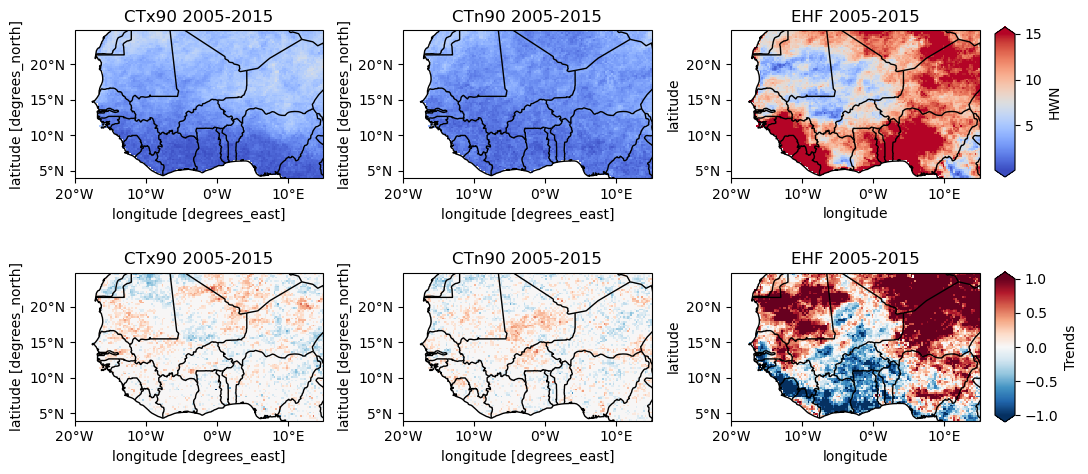

In [51]:
%%time
t1 = '2005'
t2 = '2015'
# Create subplots
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10, 5), subplot_kw={'projection': crs.PlateCarree()})
ax = ax.flatten()
set_fig_params(ax)

# Plot data
vmax=15
cc='coolwarm'

hwdtx = hwn_tx.sel(time=slice(t1,t2)).sum('time')/10
cb1 = hwdtx.where(hwdtx>0).plot(ax=ax[0], cmap=cc, vmax=vmax, add_colorbar=False)
ax[0].set_title(f'CTx90 {t1}-{t2}')


hwdtn = hwn_tn.sel(time=slice(t1,t2)).sum('time')/10
hwdtn.where(hwdtn>0).plot(ax=ax[1], cmap=cc, vmax=vmax, add_colorbar=False)
ax[1].set_title(f'CTn90 {t1}-{t2}')

ds_gtehf.where(ds_gtehf>0).sel(year=slice(t1,t2)).mean('year').plot(ax=ax[2], cmap=cc, vmax=vmax, add_colorbar=False)
ax[2].set_title(f'EHF {t1}-{t2}')

cm = 'RdBu_r'
vm = 1

txsl = hwn_tx.groupby('time.year').sum('time').sel(year=slice(t1,t2))
# txsl = txsl.where(txsl>0).load()
cb2 = sens_slopes(txsl.where(txsl>0).load()).plot(ax=ax[3], vmax=vm, cmap=cm, add_colorbar=False)
ax[3].set_title(f'CTx90 {t1}-{t2}')


tnsl = hwn_tn.groupby('time.year').sum('time').sel(year=slice(t1,t2))
sens_slopes(tnsl.where(tnsl>0).load()).plot(ax=ax[4], vmax=vm, cmap=cm, add_colorbar=False)
ax[4].set_title(f'CTn90 {t1}-{t2}')

sens_slopes(ds_gtehf.where(ds_gtehf>0).sel(year=slice(t1,t2)).load()).plot(ax=ax[5], cmap=cm, vmax=vm, add_colorbar=False)
ax[5].set_title(f'EHF {t1}-{t2}')

# # cb = [cb1, cb2]
label = ['HWN','Trends']

# cax2 = fig.add_axes([1,0.62,0.02,0.3])
# fig.colorbar(cb3,cax = cax2, orientation='vertical', extend='both',label='ehf')
cb = [cb1, cb2]
# Add colorbars
for i, j in enumerate([0.62, 0.13]):
    cax = fig.add_axes([1, j, 0.02, 0.3])
    fig.colorbar(cb[i], cax=cax, orientation='vertical', extend='both', label = label[i])

fig.tight_layout()
plt.savefig(f'{path}/figures/Climatologies of Yearly Heatwaves {t1}-{t2}.jpeg', bbox_inches='tight')

In [48]:
# txsl = hwn_tx.groupby('time.year').sum('time').sel(year=slice('1983''1993'))
# sens_slopes(txsl.where(txsl>0).load()).plot()
# sellonlat(hwn_tx.groupby('time.year').sum('time')).plot()#

In [54]:
hwn_tn.groupby('time.year').sum('time').sel(year=slice(t1,t2))#.max('year')


<xarray.DataArray 'Tmin' (year: 11, latitude: 96, longitude: 168)>
dask.array<getitem, shape=(11, 96, 168), dtype=int64, chunksize=(1, 96, 168), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -19.88 -19.62 -19.38 ... 21.38 21.62 21.88
  * latitude   (latitude) float32 3.125 3.375 3.625 3.875 ... 26.38 26.62 26.88
  * year       (year) int64 2005 2006 2007 2008 2009 ... 2012 2013 2014 2015

CPU times: user 1min 11s, sys: 29.3 s, total: 1min 40s
Wall time: 1min 10s


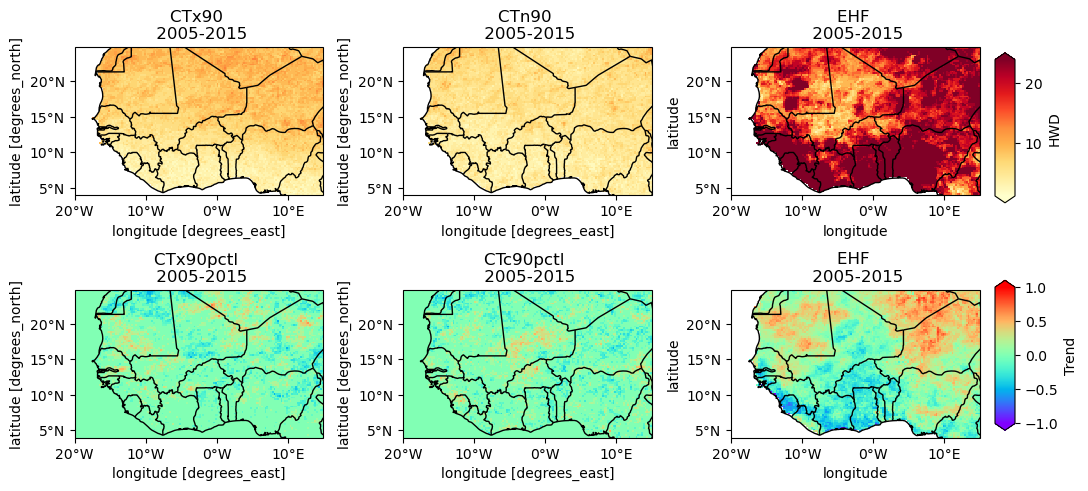

In [15]:
%%time
t1 = '2005'
t2 = '2015'
# Create subplots
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10, 5), subplot_kw={'projection': crs.PlateCarree()})
ax = ax.flatten()
set_fig_params(ax)

vmax = 24
vmax1 = 1
vmin1 = -1
# windows = candidates.chunk({'time':20}).rolling(time=5, center=True, min_periods=1).construct('rolling_dim')
# heatwave_starts = rising_filter_dask(windows, dim='rolling_dim')
cm = 'YlOrRd'
cc = 'rainbow'

sens_slopes((ds_gtehf.where(ds_gtehf>0)).sel(year=slice(t1,t2)).load()).plot(ax=ax[5], cmap=cc, add_colorbar=False)

# g=(HWD(tx)).groupby('time.year').sum('time').max('year')
# cb1 = g.where(g>0).plot(ax=ax[0], cmap=cm, add_colorbar=False, vmax=vmax)

hdtx = hwn_tx.groupby('time.year').sum('time').max('year')
cb1 = hdtx.where(hdtx>0).plot(ax=ax[0], cmap=cm, add_colorbar=False, vmax=vmax)
ax[0].set_title(f'CTx90 \n {t1}-{t2}')


# (HWD(tn)).groupby('time.year').sum('time').max('year').plot(ax=ax[1], cmap=cm, add_colorbar=False, vmax=vmax)
hdtn = hwn_tn.groupby('time.year').sum('time').sel(year=slice(t1,t2)).max('year')
hdtn.where(hdtn>0).plot(ax=ax[1], cmap=cm, add_colorbar=False, vmax=vmax)
ax[1].set_title(f'CTn90 \n {t1}-{t2}')

# ehf.mean('time').plot(ax=ax[2], cmap=cm, add_colorbar=False, vmax=vmax)

# ds_gtehf.where(ds_gtehf>0).mean('year').plot(ax=ax[2], cmap=cm, vmax=vmax, add_colorbar=False)

ds_gtehf.where(ds_gtehf>0).sel(year=slice(t1,t2)).max('year').plot(ax=ax[2], cmap=cm, vmax=vmax, add_colorbar=False)
ax[2].set_title(f'EHF \n {t1}-{t2}')

# sens_slopes((HWD(tx.load())).groupby('time.year').sum('time').load()).plot()

cb2 = sens_slopes((HWD(tx.load())).groupby('time.year').sum('time').sel(year=slice(t1,t2)).load()).plot(ax=ax[3], cmap=cc, add_colorbar=False, vmax = vmax1, vmin=vmin1)
sens_slopes((HWD(tn.load())).groupby('time.year').sum('time').sel(year=slice(t1,t2)).load()).plot(ax=ax[4], cmap=cc, add_colorbar=False, vmax = vmax1, vmin=vmin1)
# sens_slopes((ds_gtehf.where(ds_gtehf>0)).load()).plot(ax=ax[5], cmap=cc, add_colorbar=False, vmax = vmax1, vmin=vmin1)

# sens_slope(tn.load()).plot(ax=ax[4], cmap=cc, add_colorbar=False, vmax = vmax1, vmin=vmin1)
# sens_slope(ehf.load()).plot(ax=ax[5], cmap=cc, add_colorbar=False, vmax = vmax1, vmin = vmin1)


ax[3].set_title(f'CTx90pctl \n {t1}-{t2}')
ax[4].set_title(f'CTc90pctl \n {t1}-{t2}')
ax[5].set_title(f'EHF \n {t1}-{t2}')

# Add colorbar
cb = [cb1, cb2]
labels = ['HWD','Trend']
# cax2 = fig.add_axes([1,0.13,0.02,0.3])
# fig.colorbar(cb3,cax = cax2, orientation='vertical', extend='both',label='ehf-Trend')

for i, j in enumerate([0.585, 0.13]):
    cax = fig.add_axes([1, j, 0.02, 0.3])
    fig.colorbar(cb[i], cax=cax, orientation='vertical', extend='both', label=labels[i])

fig.tight_layout()
plt.savefig(f'{path}/figures/lenght of the longest heatwave {t1}-{t2}.jpeg', bbox_inches='tight')

In [16]:
# yearly_av_hw_tx = hwn_tx.sum('time')/33
# lenght_av_hw_tx = hwn_tx.groupby('time.year').sum('time').mean('year')

NameError: name 'hwf_tx' is not defined

In [ ]:
%%time

# tx = xr.open_dataset(f'{path1}/Tmax/chirts.Tmax.1983.2016.WA.days_p25.nc').Tmax.sortby('time').drop_duplicates('time').chunk({'time': 20})
# tn = xr.open_dataset(f'{path1}/Tmin/chirts.Tmin.1983.2016.WA.days_p25.nc').Tmin.sortby('time').drop_duplicates('time').chunk({'time': 20})

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 5), subplot_kw={'projection': crs.PlateCarree()})
ax = ax.flatten()
set_fig_params(ax)

vmax = 26

# cm = 'viridis'
cc = 'Set2'

cb = hwf_tx.where(hwf_tx>0).plot(ax=ax[0], cmap=cc, vmax=vmax, add_colorbar=False)

# .plot(ax=ax[0], cmap=cc, vmax=vmax, add_colorbar=False)

hwf_tn.where(hwf_tn>0).plot(ax=ax[1], cmap=cc, vmax=vmax, add_colorbar=False)

# ehf.groupby('time.year').sum().mean('year').plot(ax=ax[2], cmap=cc, add_colorbar=False)
# (ehf.where(ehf>0,drop=True).rolling(time=3).sum()).mean('time').plot(ax=ax[2], cmap=cc, add_colorbar=False)
hwf_ehf.plot(ax=ax[2], cmap=cc, add_colorbar=False)
ax[2].set_title('EHF \n 1983-2016')



# sens_slope(HWF(path1, 'Tmax/tx-tx90.nc', temperature_type='Tmax', var = 'Tmax')).plot(ax=ax[3], cmap=cc)
# sens_slope(HWF(path1, 'Tmin/tn-tn90.nc', temperature_type='Tmin', var = 'Tmin')).plot(ax=ax[4], cmap=cc)
# sens_slope(HWF_ehf(path1, 'scripts/EHF.nc', var = 'Tmax')).plot(ax=ax[5], cmap=cc)

ax[0].set_title('CTx90pct \n 1983-2016')
ax[1].set_title('CTn90pct \n 1983-2016')
# ax[5].set_title('EHF \n 1983-2016')

# cb = [cb1, cb2]
# labels = ['HWF','Trends']
# # Add colorbars
# for i, j in enumerate([0.59, 0.13]):
#     cax = fig.add_axes([1, j, 0.02, 0.3])
#     fig.colorbar(cb[i], cax=cax, orientation='vertical', extend='both', label=labels[i])
cax = fig.add_axes([1,0.35,0.02,0.3])
fig.colorbar(cb, cax=cax, orientation='vertical', extend='both', label='HWF')

fig.tight_layout()
#plt.savefig(path+'/figures/Yearly Number of Participating Heatwave Day.jpeg', bbox_inches='tight')